In [6]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
#DATA_ROOT = '/content/drive/My Drive/Final-Project-for-CS109a/Milestone3/'
DATA_ROOT = './Data/'
random_state = 109

In [7]:
new_york_crime_data_df = pd.read_csv(DATA_ROOT + 'nyc_crime_analysis_data_final_corrected.csv').drop(columns=["Unnamed: 0"])
boston_crime_data_df = pd.read_csv(DATA_ROOT + 'boston_crime_analysis_data_final_corrected.csv').drop(columns=["Unnamed: 0"])
combined_crime_data_df = pd.concat([boston_crime_data_df, new_york_crime_data_df])

In [8]:
boston_crime_train, boston_crime_test = train_test_split(boston_crime_data_df, train_size=.8, random_state = random_state)
comb_crime_train, comb_crime_test = train_test_split(combined_crime_data_df, train_size=.8, random_state = random_state)

In [9]:

train_offenses = comb_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = comb_crime_train[comb_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = comb_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = comb_crime_test[comb_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (Combined) : {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime (Combined) : 0.118
Naive Model Train Accuracy when classifying all offenses as not violent: 0.882
Naive Model Test Accuracy when classifying all offenses as not violent: 0.882


In [10]:
# Offense Type Logistic Regression

# we'll predict Offense Types in combined set using all features (minus the other response variable for Offense Type)
demog_category_columns = ['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR']
train_crime_demog_dummies_df = pd.get_dummies(comb_crime_train.drop(columns=["OFFENSE_TYPE","VIOLENT_CRIME","GEOHASH",'LATITUDE','LONGITUDE']), columns=demog_category_columns)
test_crime_demog_dummies_df = pd.get_dummies(comb_crime_test.drop(columns=["OFFENSE_TYPE","VIOLENT_CRIME","GEOHASH",'LATITUDE','LONGITUDE']), columns=demog_category_columns)

# select all columns from dummies minus response and Geohash 
x_columns = train_crime_demog_dummies_df.columns

X_train = train_crime_demog_dummies_df[x_columns]
X_test = test_crime_demog_dummies_df[x_columns]

demog_scaler = MinMaxScaler()
demog_scaler.fit(X_train)
x_train_norm = demog_scaler.transform(X_train)
x_test_norm = demog_scaler.transform(X_test)

y_train = comb_crime_train['OFFENSE_TYPE'].values
y_test = comb_crime_test['OFFENSE_TYPE'].values

# attempt a baseline logistic regression with regularization
demog_logit_full_combo = LogisticRegressionCV(penalty='l2', max_iter = 10000,multi_class='multinomial',)
demog_logit_full_combo.fit(x_train_norm,y_train)
demog_logit_full_combo_train_accuracy = round(demog_logit_full_combo.score(x_train_norm, y_train),3)
demog_logit_full_combo_test_accuracy = round(demog_logit_full_combo.score(x_test_norm, y_test),3)

In [11]:
print(f"\nLogisitic Train Accuracy: {demog_logit_full_combo_train_accuracy}, Logistic Test Accuracy: {demog_logit_full_combo_test_accuracy}")


Logisitic Train Accuracy: 0.424, Logistic Test Accuracy: 0.422


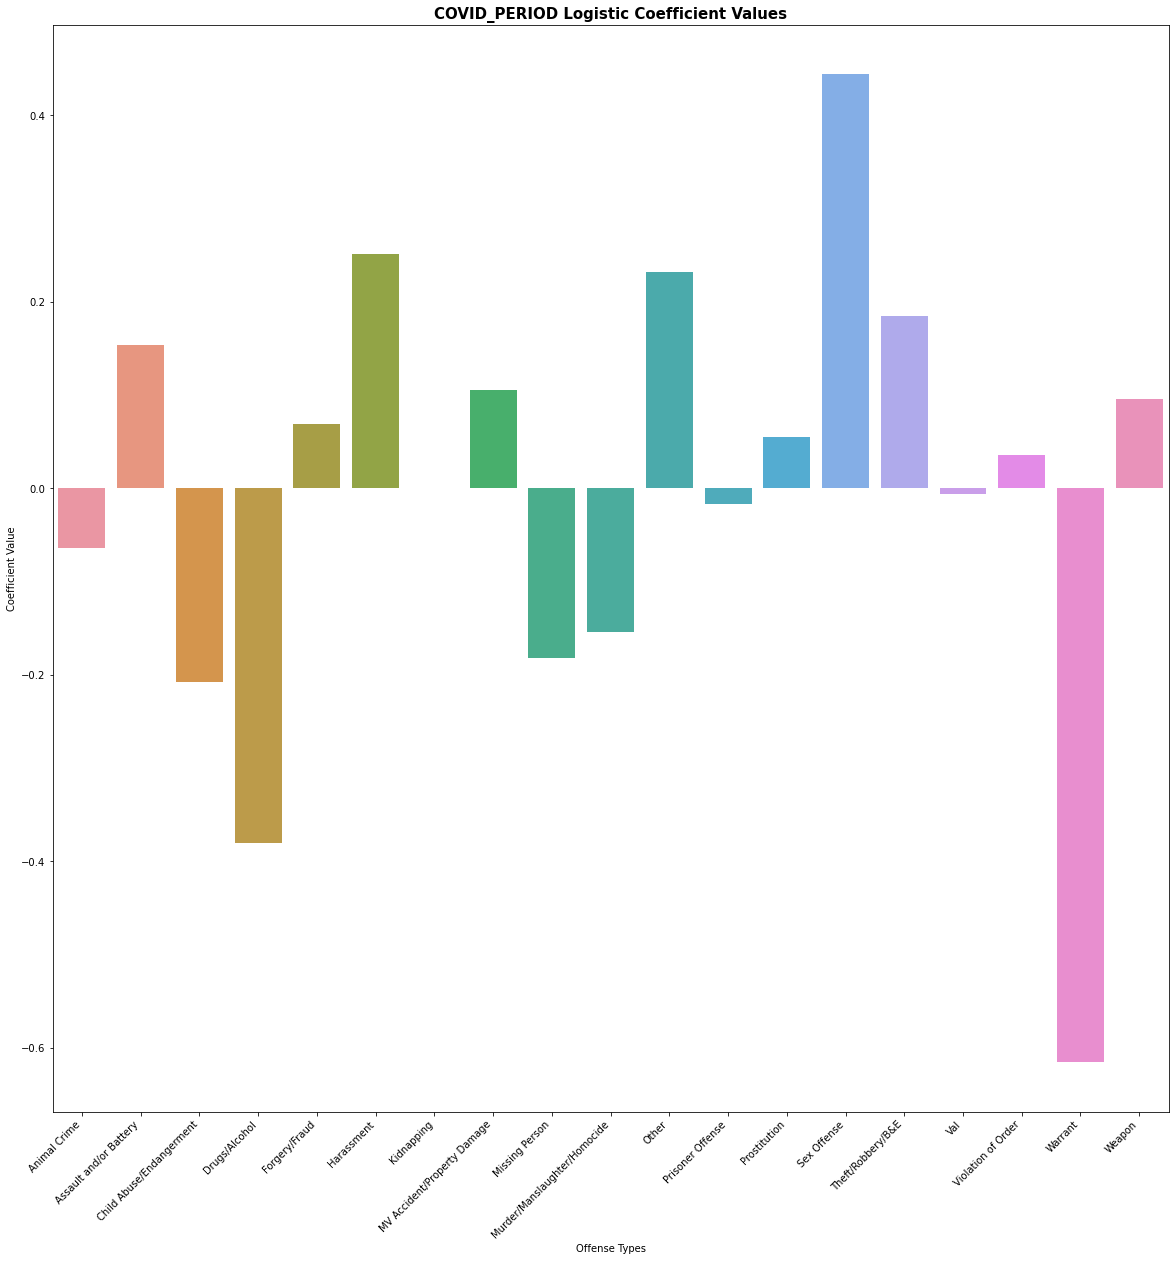

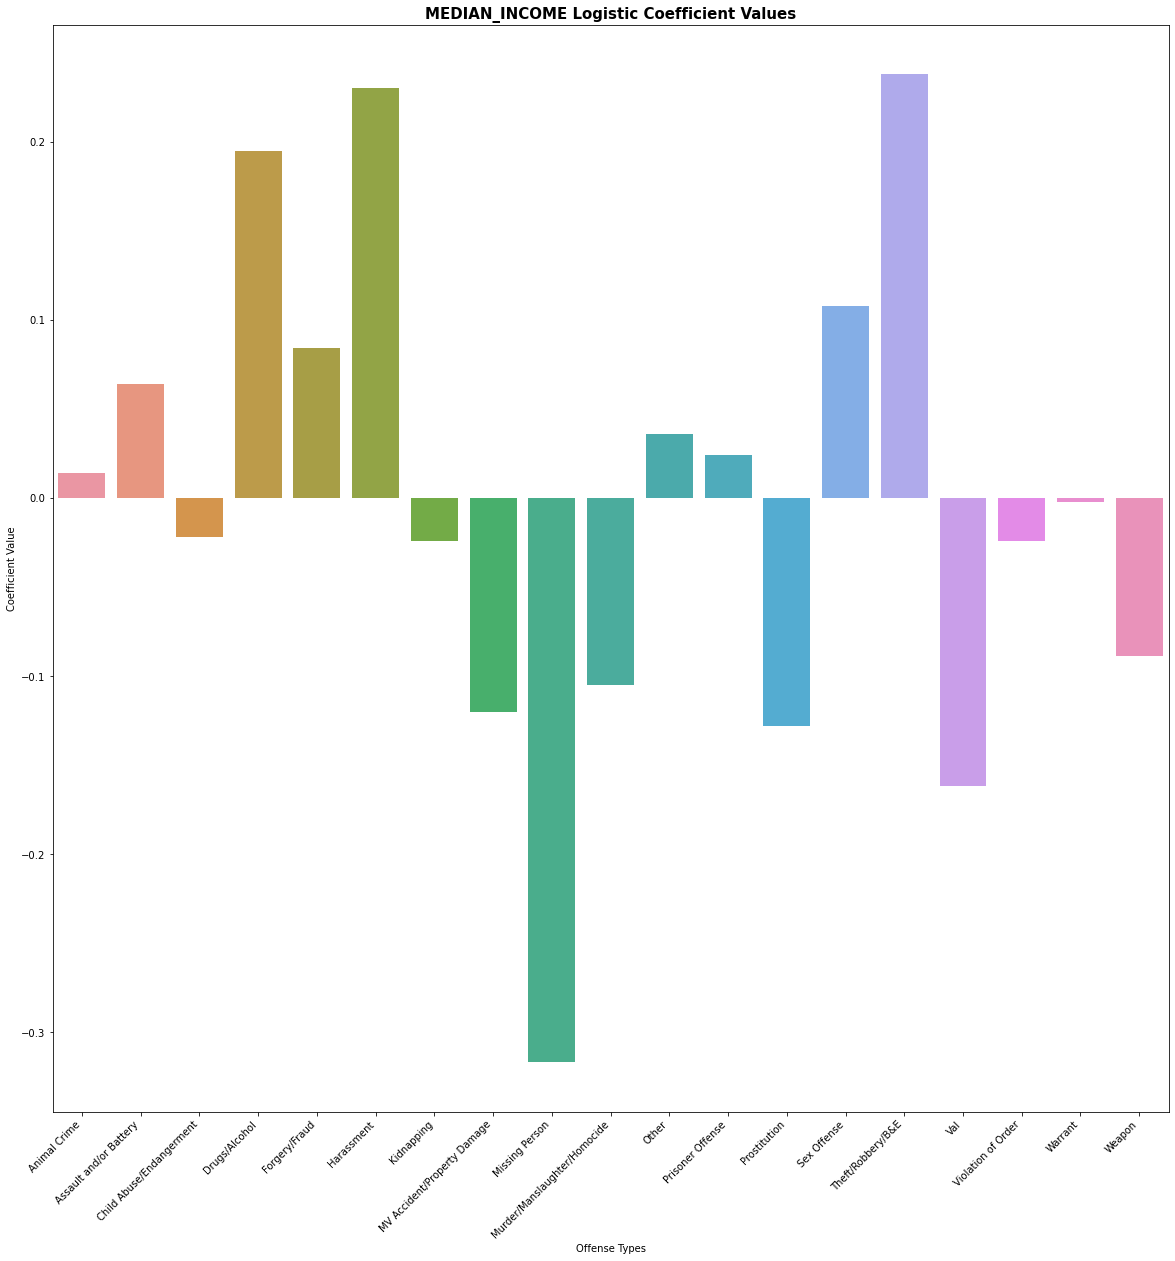

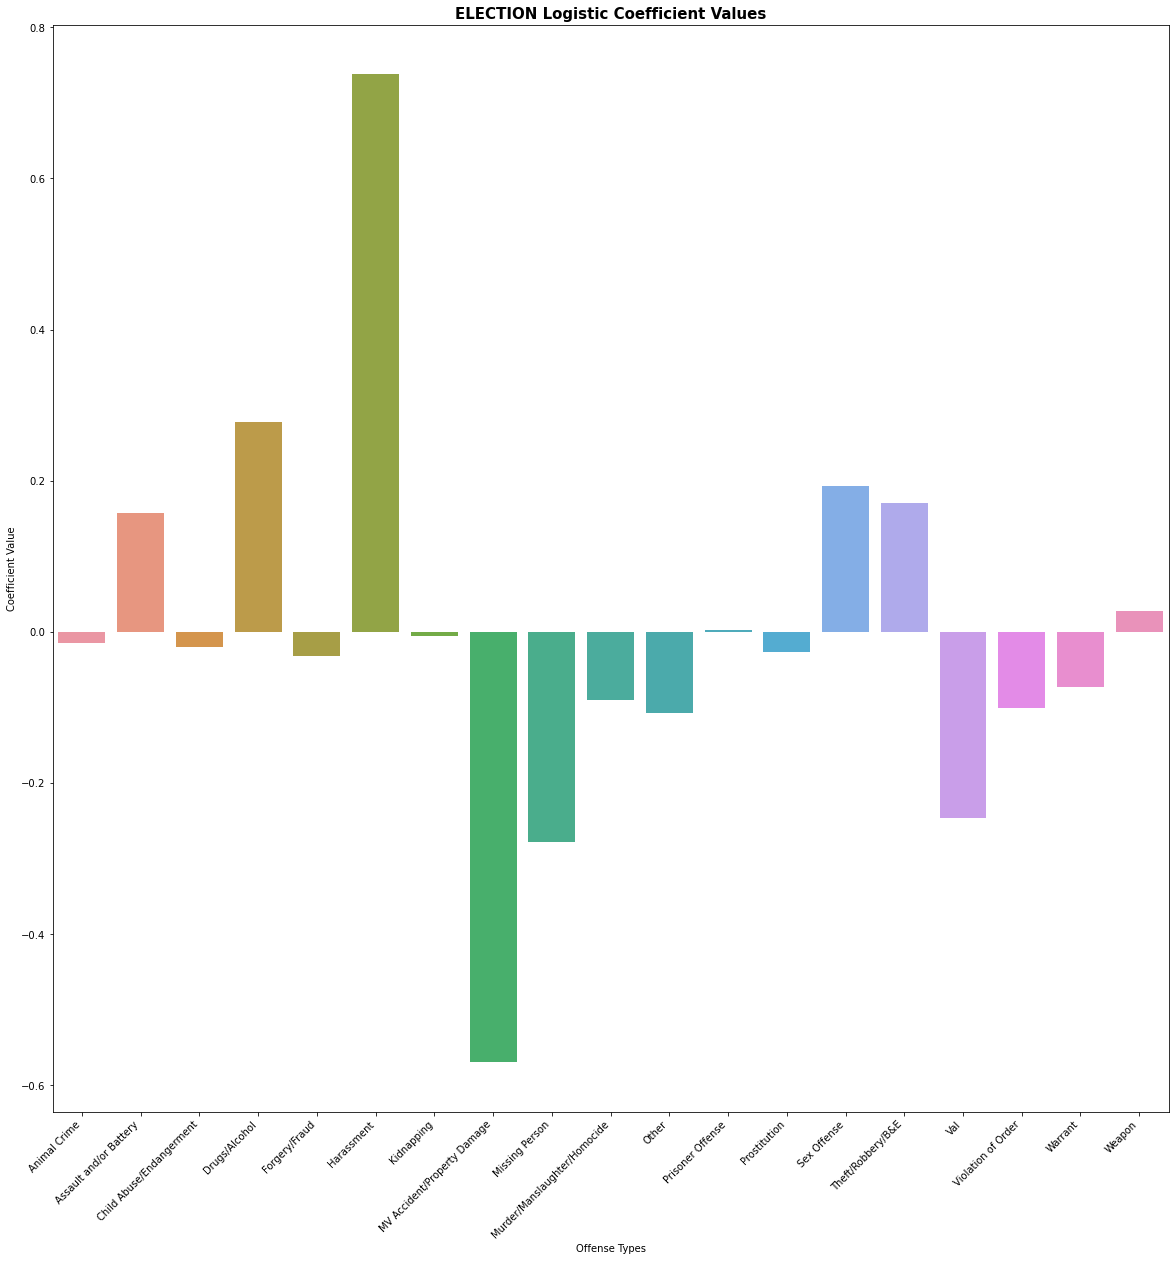

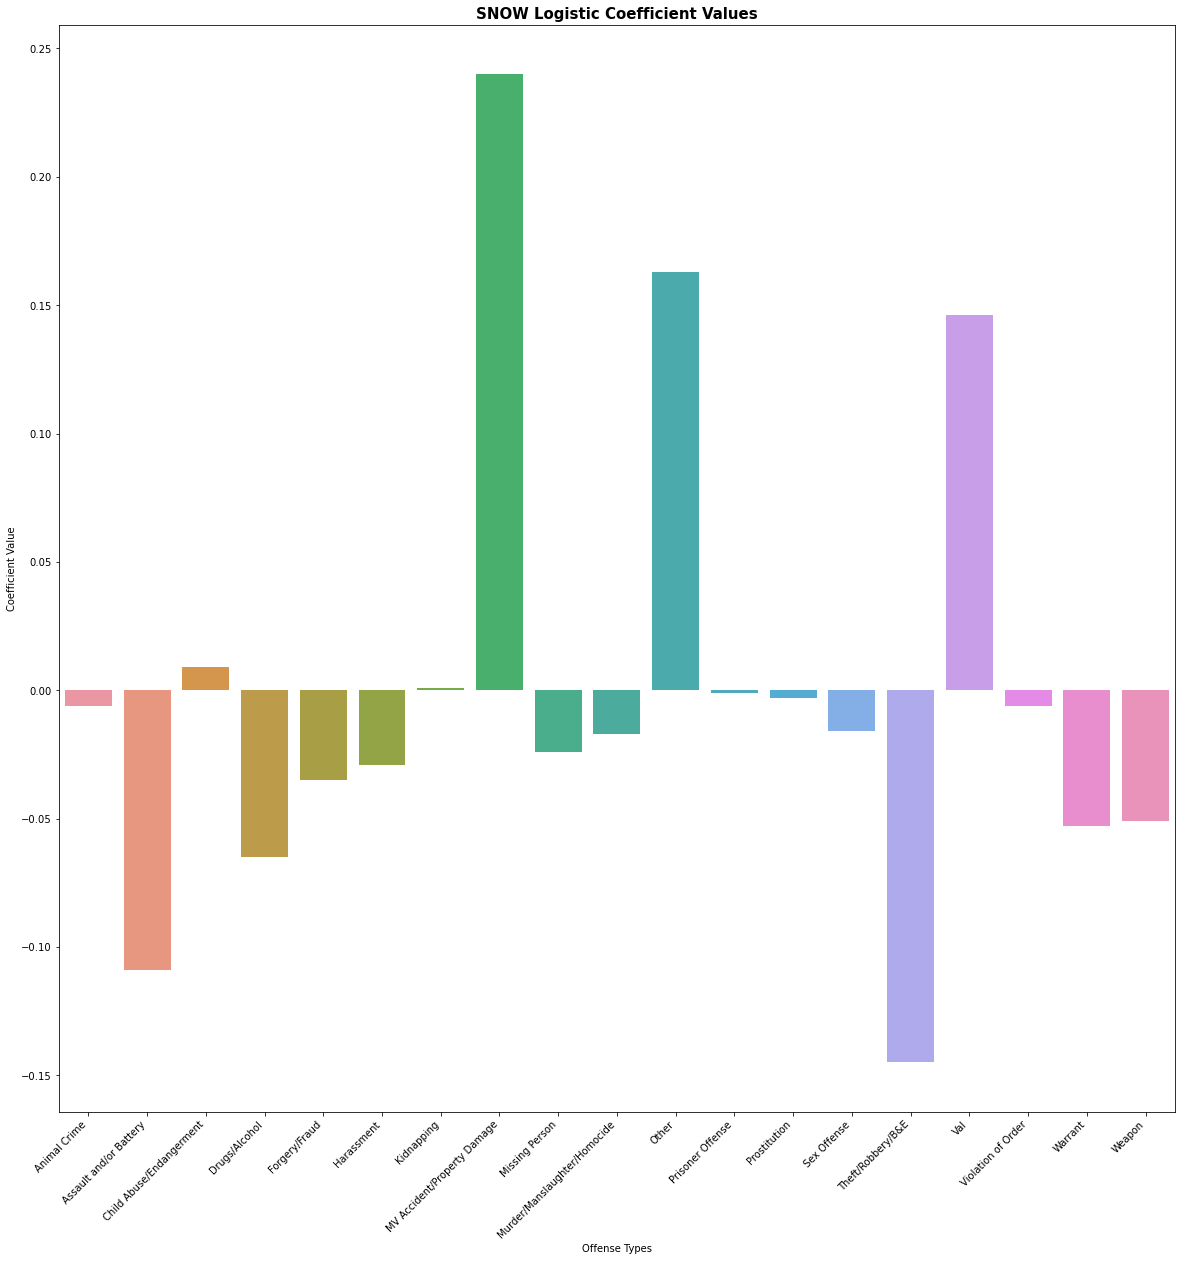

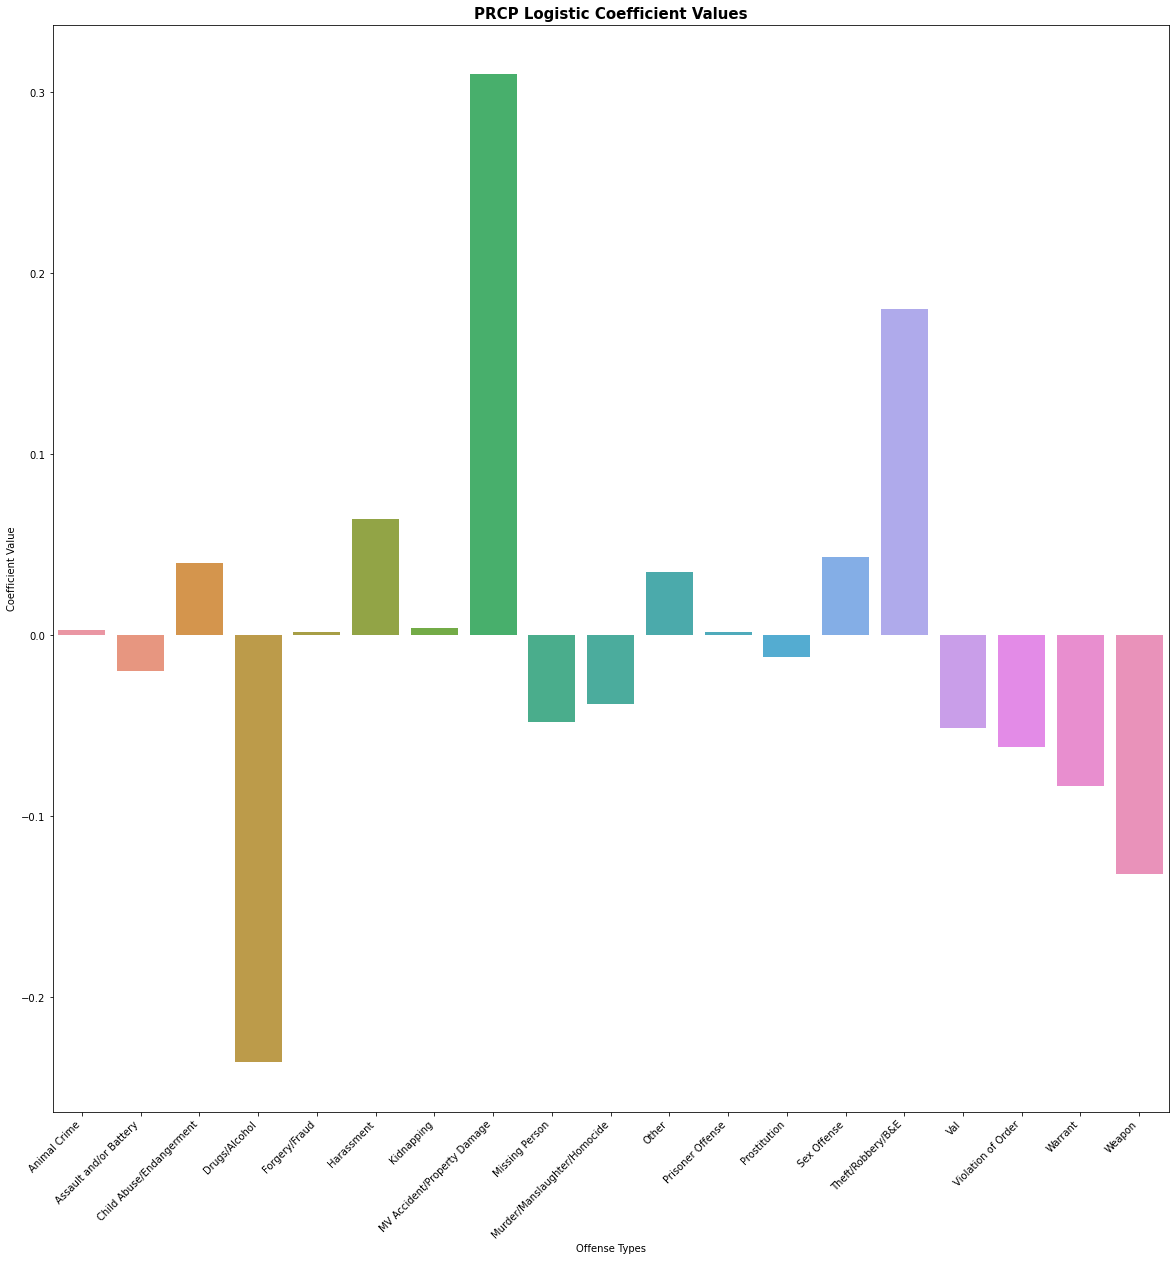

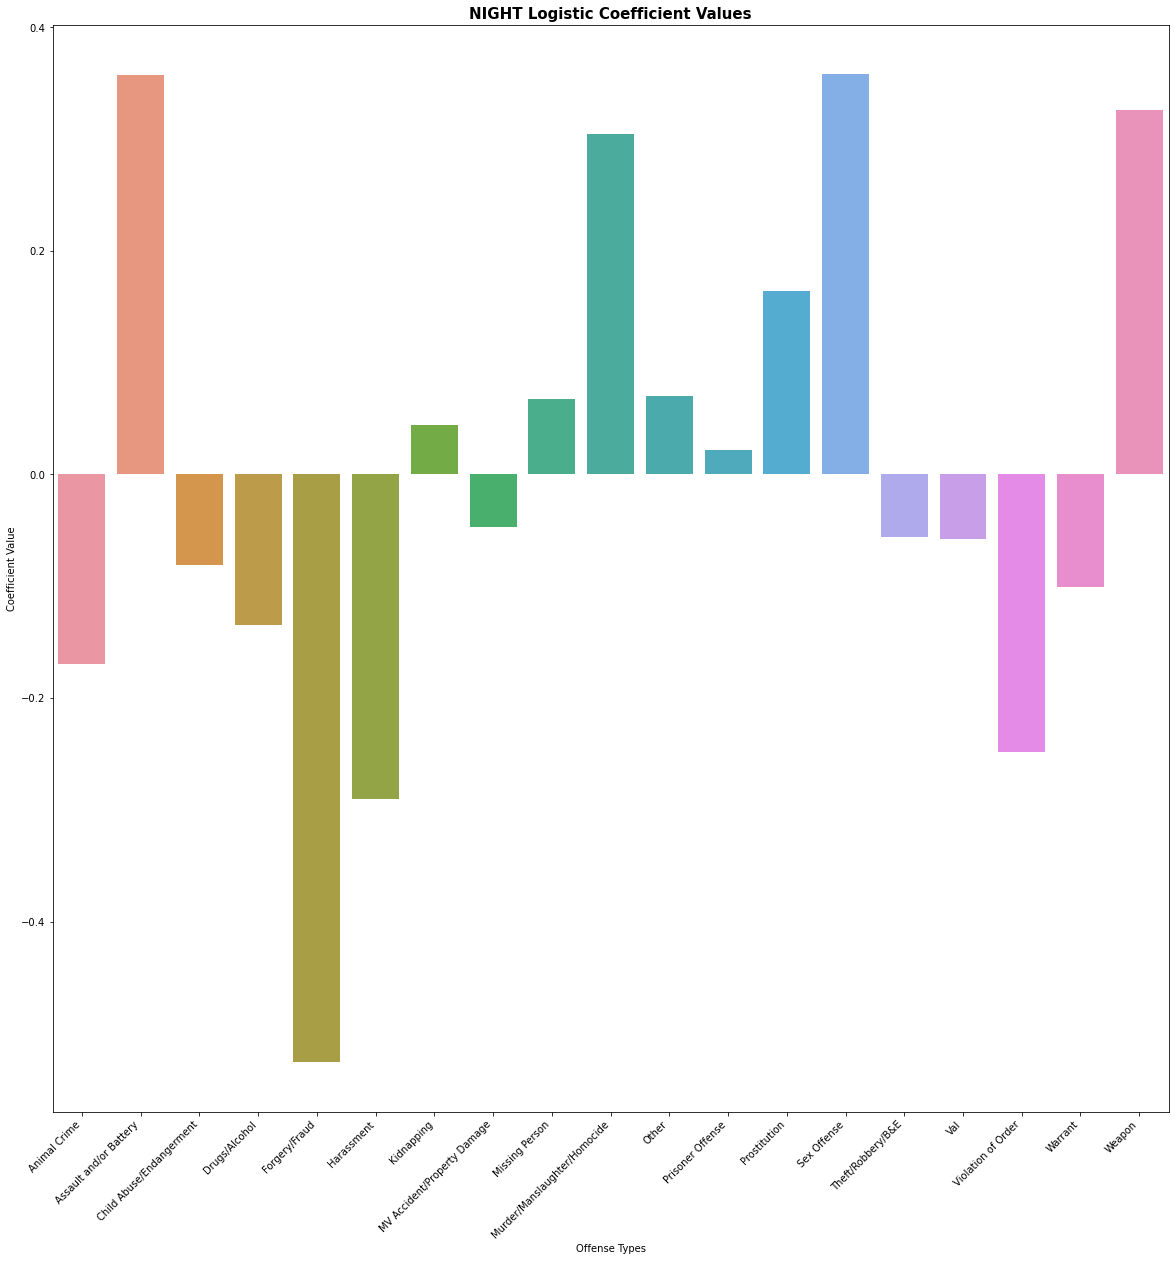

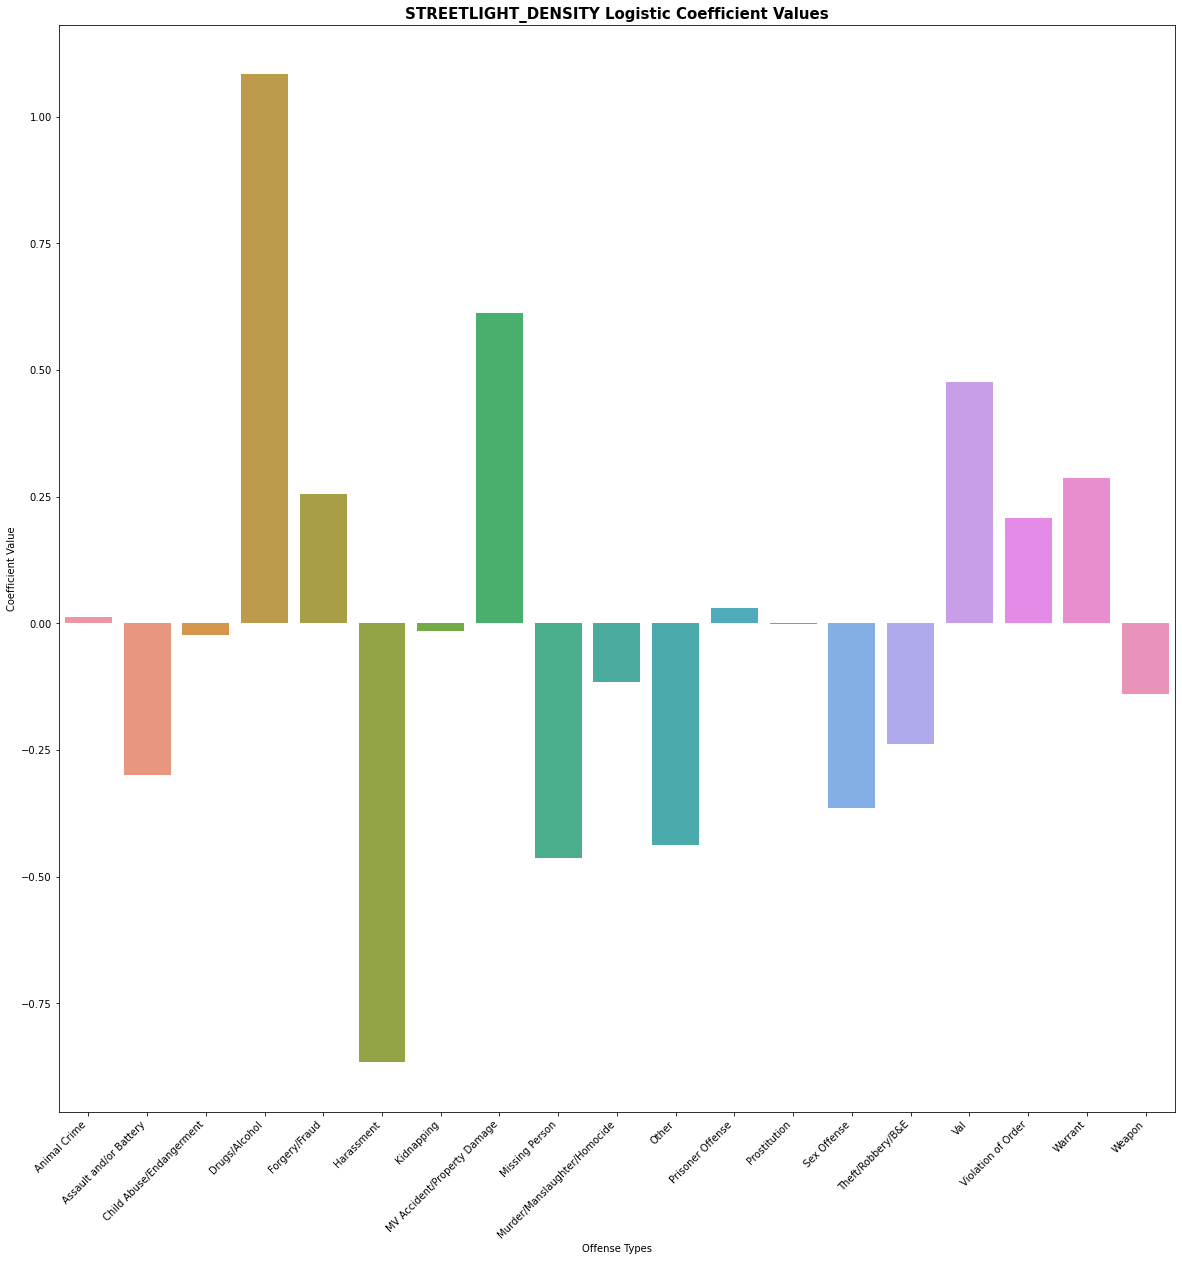

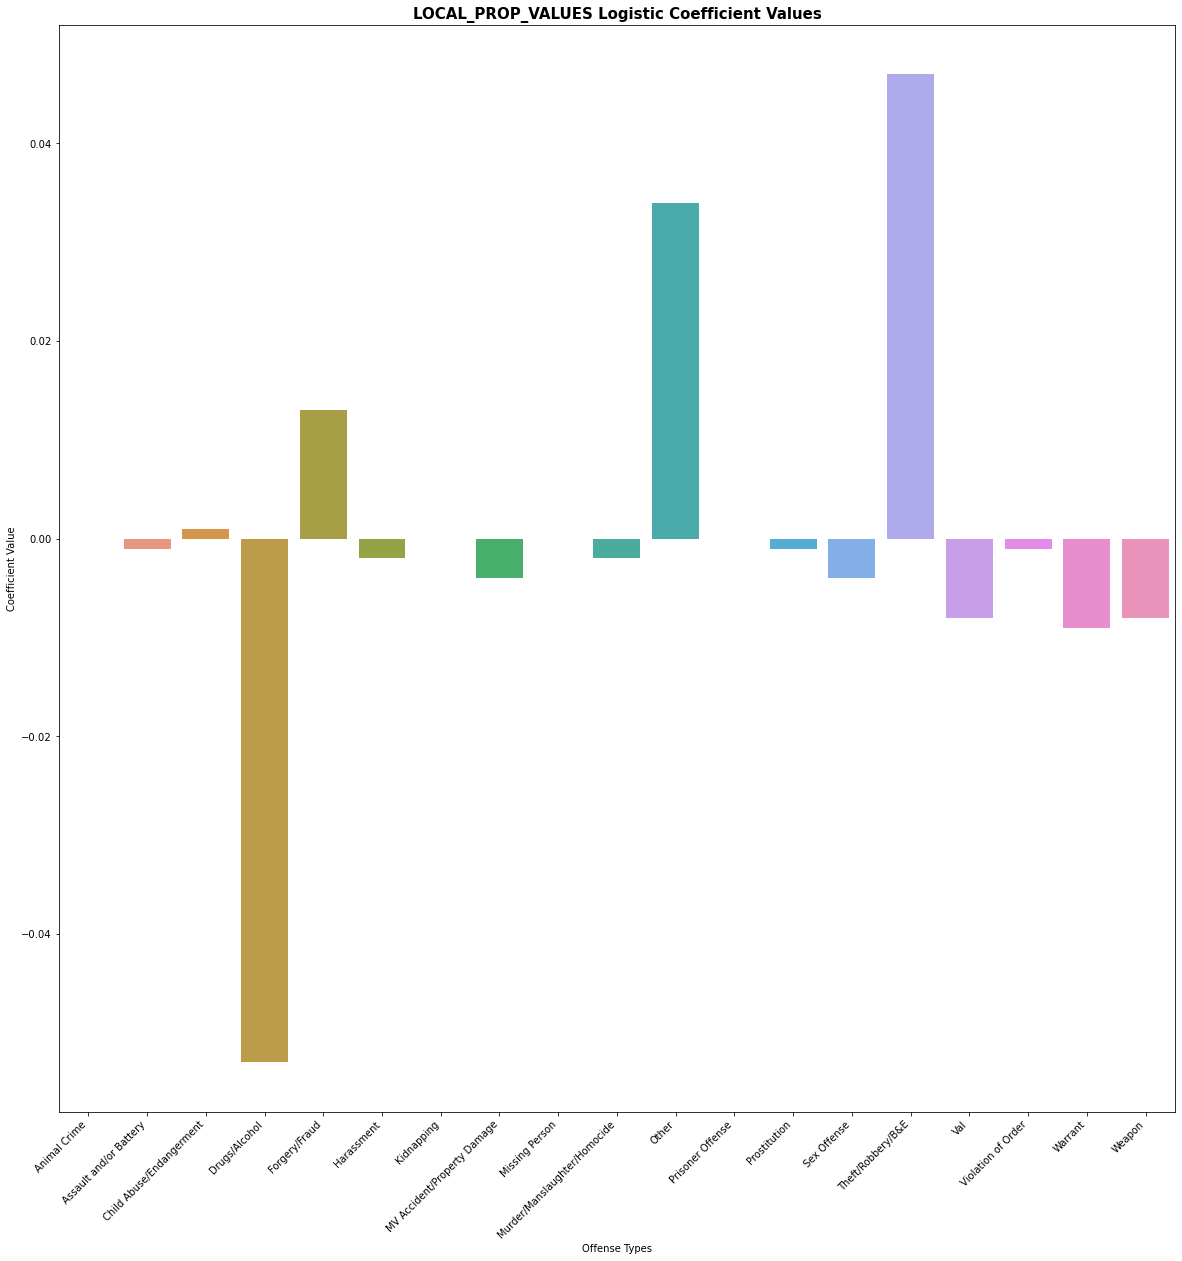

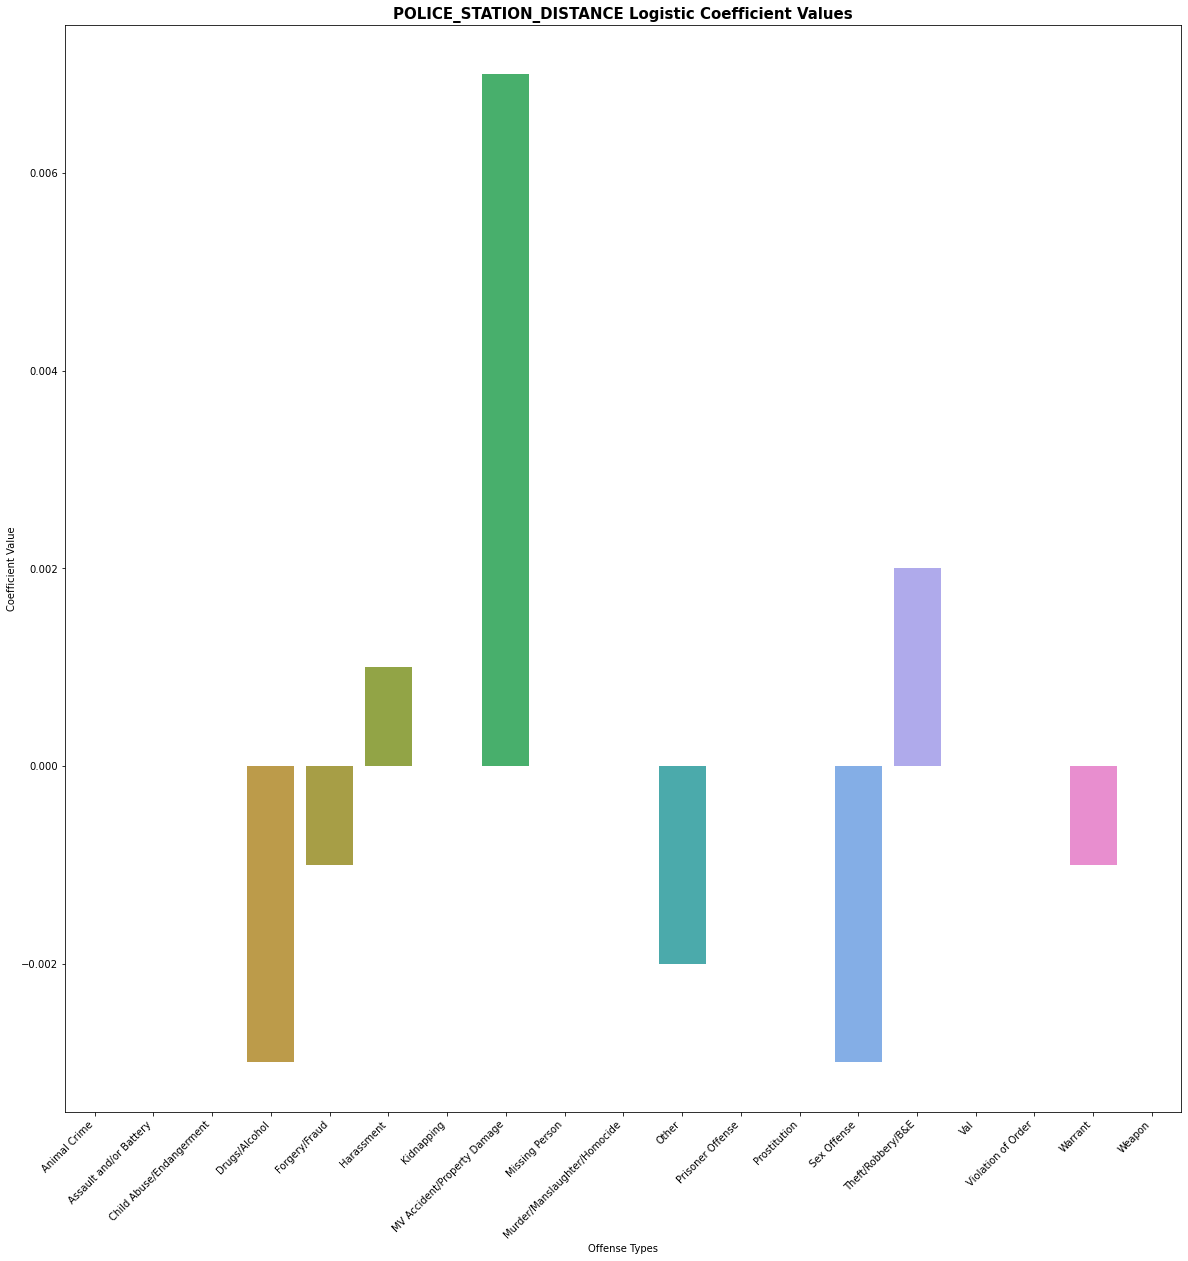

In [12]:
# Graph coefficent for each predicted value per feature
coeffs = {}

for i, k in enumerate(x_columns): 
    x = []
    y = []
    for j, classification in enumerate(demog_logit_full_combo.classes_):
      x.append(classification)
      y.append(round(demog_logit_full_combo.coef_[j][i],3))
    coeffs[k] = {"x": x, "y":y}  

for i, k in enumerate(["COVID_PERIOD","MEDIAN_INCOME","ELECTION","SNOW","PRCP","NIGHT","STREETLIGHT_DENSITY","LOCAL_PROP_VALUES","POLICE_STATION_DISTANCE"]):
  fig, ax = plt.subplots(figsize=(20,20))
  sns.barplot(x=coeffs[k]["x"], y=coeffs[k]["y"],ax=ax)
  ax.set_title(f"{k} Logistic Coefficient Values", fontdict={ 'weight' : 'bold','size': 15})
  ax.set_ylabel("Coefficient Value")
  ax.set_xlabel("Offense Types")
  ax.set_xticklabels(coeffs[k]["x"], rotation = 45, ha="right")
  plt.show()